<a href="https://colab.research.google.com/github/fares-3adi/FraudDetectionProject/blob/main/FYP_NOTEBOOK_FINAL_VERSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Card Fraud Detection Using Supervised Machine Learning**

## Initial Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

## Dataset and Acknowledgements

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Link to Dataset: https://www.openml.org/search?type=data&status=active&id=42175

Citations:
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Ael; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Ael; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Ael Le Borgne, Liyun He, Frederic Oble, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Ael Le Borgne, Olivier Caelen, Frederic Oble, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Loading the dataset directly from google drive to avoid
# not fully loading it
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab/CS3IP/creditcard.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For reference: The column names are Time, V1 ... V28, Amount, and Class

In [3]:
# just to ensure entire dataset was loaded, should show 284k records by the tail
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


# **1. Exploratory Data Analysis**

In this section, we examined the transaction data to understand feature distributions, detect anomalies, and assess class imbalance. Insights from this analysis directly informed decisions such as transformations, feature selection, sampling strategies and so on in preprocessing.


## **1.1. Histogram/KDE Plots**



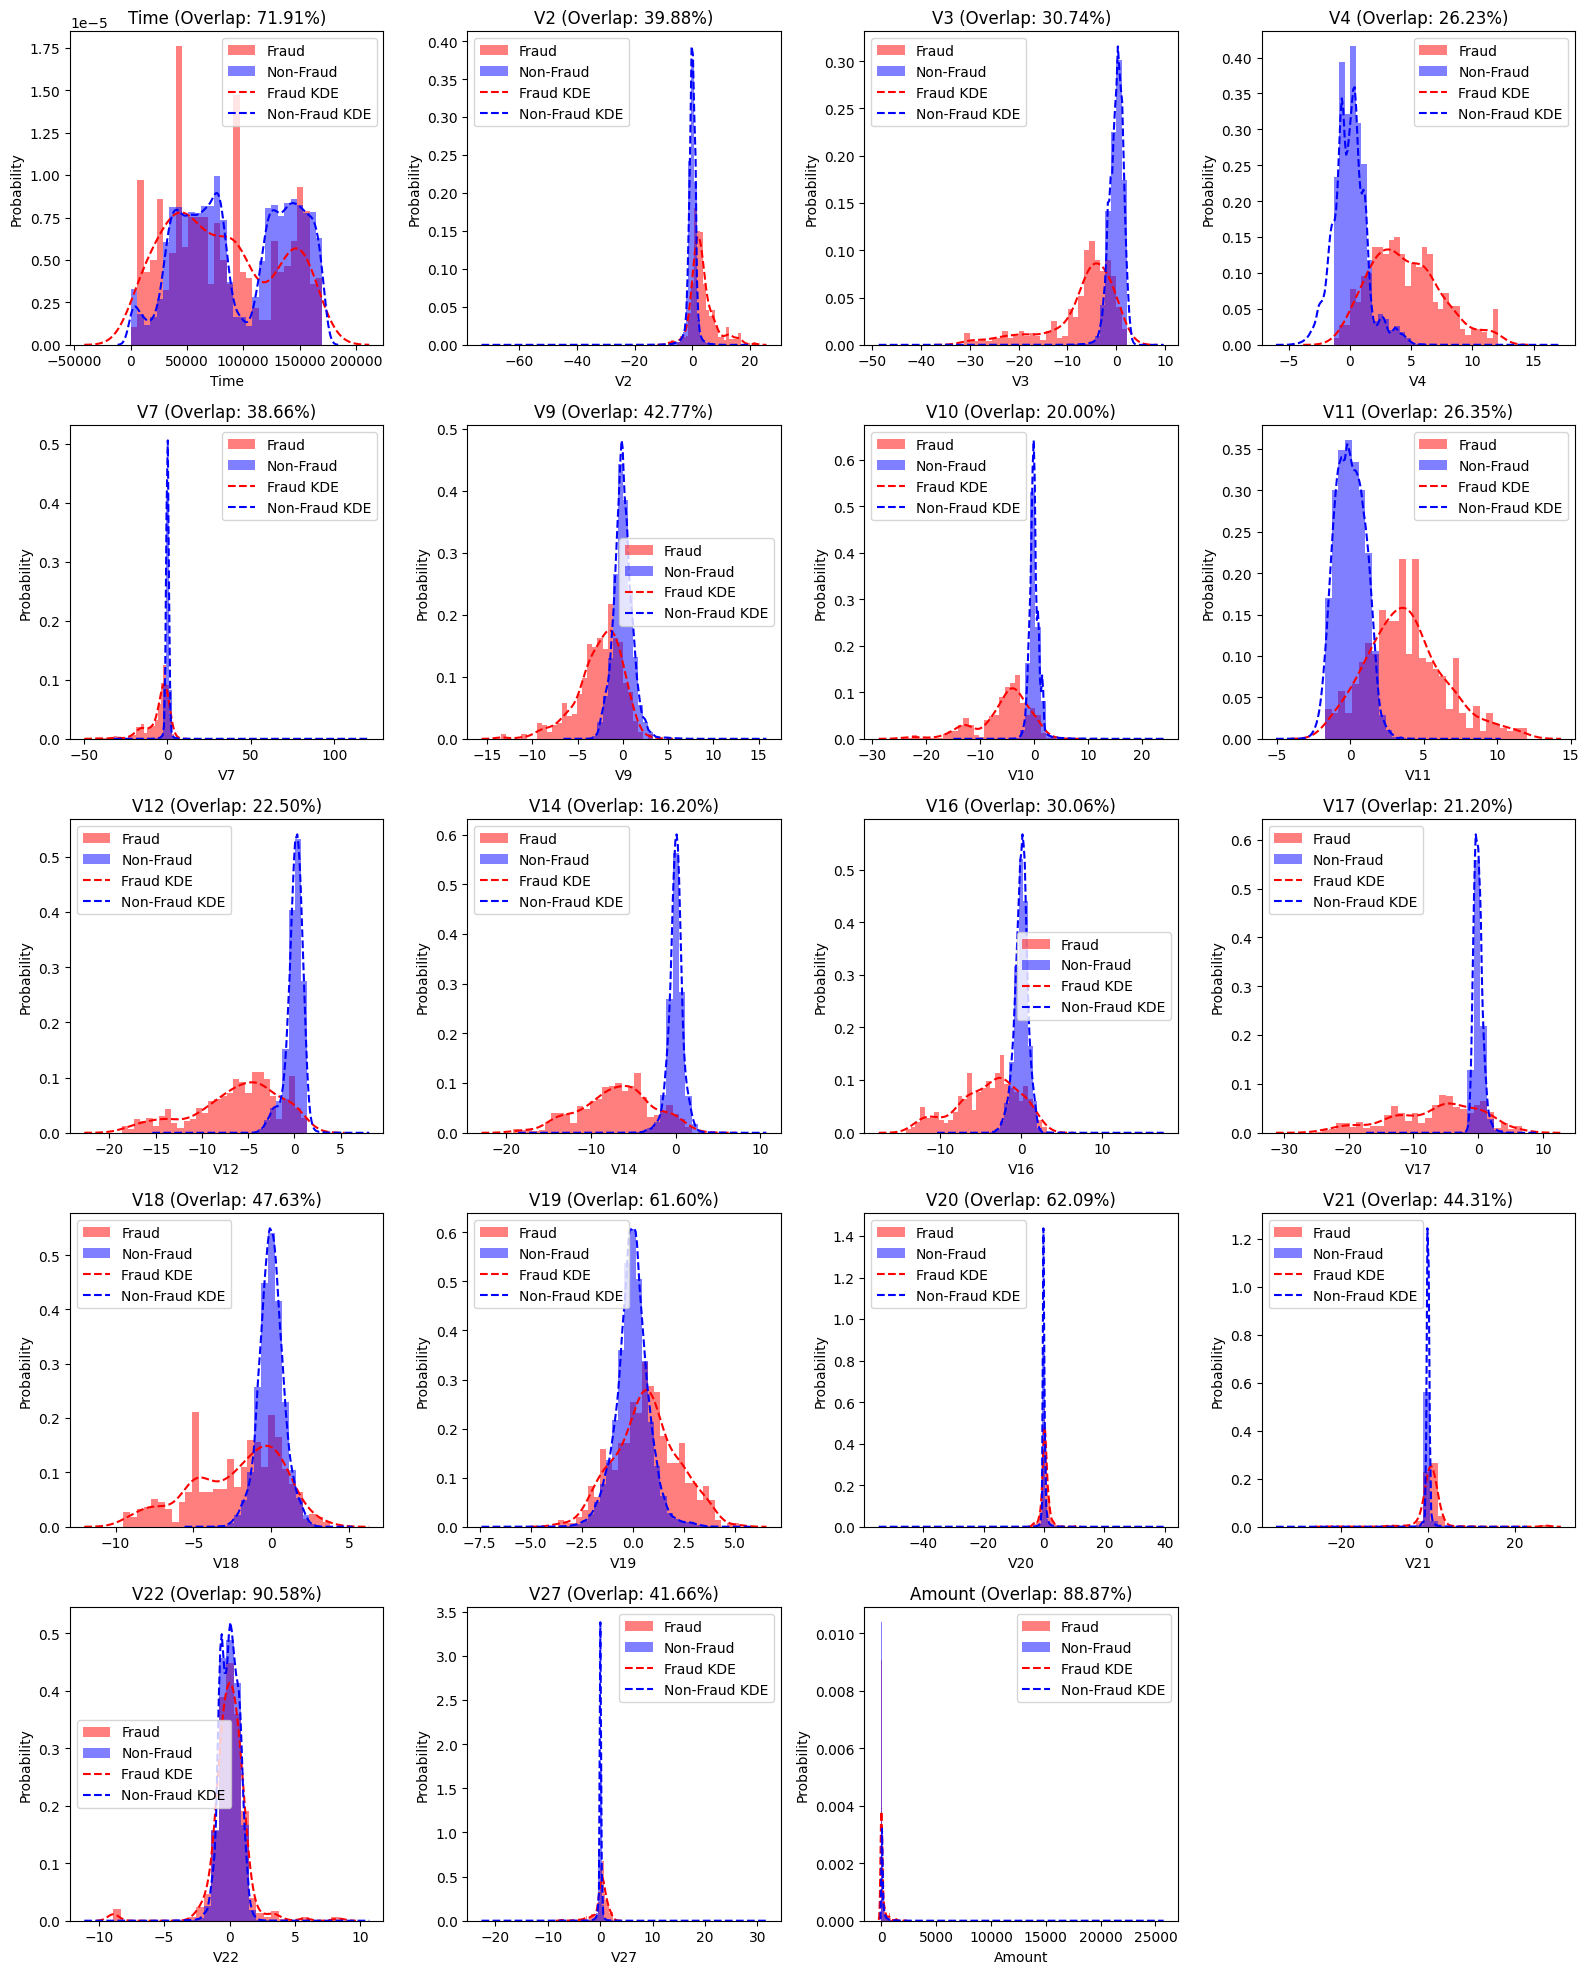

In [37]:
import seaborn as sns

# function to calculate percentage overlap
def calculate_overlap(hist1, hist2, bin_widths):
  overlap_area = np.sum(np.minimum(hist1, hist2) * bin_widths)
  return overlap_area * 100  # Convert to percentage

# plotting histograms with KDE overlays
num_cols = len(df.columns) - 1
num_rows = (num_cols + 3) // 4

plt.figure(figsize=(16, 4 * num_rows))

for i, label in enumerate(df.columns[:-1], 1):  # exclude the class column
  plt.subplot(num_rows, 4, i)

  # create histograms
  fraud_data, bins = np.histogram(df[df["Class"] == 1][label], bins=30, density=True)
  non_fraud_data, _ = np.histogram(df[df["Class"] == 0][label], bins=bins, density=True)

  # calculate bin widths
  bin_widths = np.diff(bins)

  # calculate overlap
  overlap_percentage = calculate_overlap(fraud_data, non_fraud_data, bin_widths)

  # plot histograms
  plt.hist(df[df["Class"] == 1][label], bins=bins, color="red", alpha=0.5, density=True, label="Fraud")
  plt.hist(df[df["Class"] == 0][label], bins=bins, color="blue", alpha=0.5, density=True, label="Non-Fraud")

  # add KDE lines to the same plot
  sns.kdeplot(df[df["Class"] == 1][label], color="red", label="Fraud KDE", linestyle="dashed")
  sns.kdeplot(df[df["Class"] == 0][label], color="blue", label="Non-Fraud KDE", linestyle="dashed")

  # add title with overlap percentage
  plt.title(f"{label} (Overlap: {overlap_percentage:.2f}%)")
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()

plt.tight_layout()
plt.show()


### Analyzing Overlap for Feature Selection

**Note**: The overlap percentage displayed on top of each histogram shows the percentage by which the two classes overlap for that given feature. A lower percentage overlap indicates a greater divide between the two classes given a classification based on that feature.

**The aim here is to look for the following categories of features:**
- Features with an overlap of over 60% would indicate low discriminative power and would therefore be dopped.
- Features with an overlap under 40% would indicate high discriminative power and would therefore be retained.
- Features with an overlap in the middle range of 40-60% would require further analysis in order to determine whether they should be dropped or retained.

**Observing the results:**

Features with an overlap of 40% or below are (To Be Retained):
- V2 (39.88%)
- V3 (30.74%)
- V11 (26.35%)
- V12 (22.50%)
- V14 (16.20%)
- V16 (30.06%)
- V17 (21.20%)
- V27 (41.66%)


Features with an overlap above 60% (To Be Dropped):
- V8 (66.75%)
- V15 (89.62%)
- V21 (90.58%)
- V22 (85.60%)
- V24 (79.95%)
- V25 (85.60%)
- V26 (84.30%)

Features with an overlap of 40-60%, needing further analysis (Using Random Forest):
- V1 (54.20%)
- V6 (51.37%)
- V9 (42.77%)
- V28 (50.24%)



## **1.2. Random Forest Feature Importance for All Dataset Features**

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Best CV Score (Average Precision): nan

Feature Importances from Best RF Model:
 V14      0.25
V10      0.16
V12      0.12
V4       0.09
V17      0.08
V11      0.06
V3       0.05
V16      0.04
V7       0.02
Amount   0.02
V20      0.02
V19      0.01
V21      0.01
V2       0.01
V18      0.01
V9       0.01
V27      0.01
V22      0.01
Time     0.01
dtype: float64


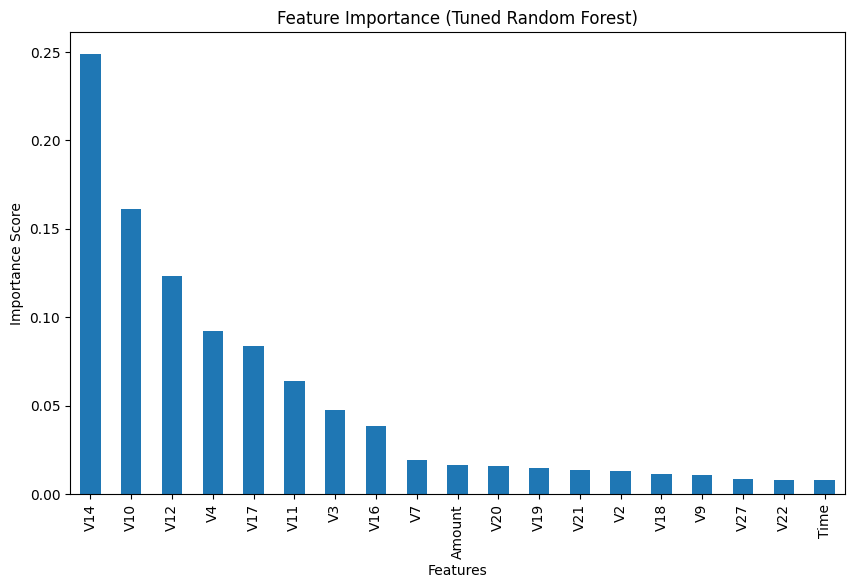

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score

# seprating features (x) and target (y)
X = df.drop(columns=['Class'])
y = df['Class']

# defining parameter grid for random forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'max_features': ['sqrt', 'log2']
}

# using average precision as a performance metric for imbalanced data
avg_precision_scorer = make_scorer(average_precision_score, needs_proba=True)

# creating a random forest model with class weighting for imbalance
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# setting up cross-validation and GridSearch
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    rf,
    param_grid=param_grid,
    scoring=avg_precision_scorer,
    cv=cv,
    n_jobs=-1
)

# running the grid search
grid_search.fit(X, y)

# retrieve and print best parameterss and best cv score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (Average Precision):", grid_search.best_score_)

# getting the best model and extracting feature importances
best_rf = grid_search.best_estimator_
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances from Best RF Model:\n", feature_importances)

# plotting the feature importnces
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', title="Feature Importance (Tuned Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=90)
plt.show()


Based on the feature importance scores shown in the above plot, it can be seen that features such as V14, V10 and V12 possess high importance.

This means they hold high predictive power when it comes to model performance. Whereas, features such as V24, V25 and V15, ones with a low feature importnace score, hold low predictive power.

Therefore, we are likely to see better performance, if those features are dropped (ones with low predictive score).

## **1.3. Feature Importance with SHAP**

- To explain how SHAP plots work, the x-axis represents the SHAP value, which indicates how much a feature pushes the model's prediction towards fraud (positive SHAP values) or non-fraud (negative SHAP values)

  - Points that are further to the right (positive SHAP values) mean the feature contributes to predicting fraud (Class = 1).

  - Points that are further to the left (negative SHAP values) mean the feature contributes to predicting non-fraud (Class = 0).

- The color gradient represents the features values where:

  - Blue represents low features values.
  - Red represents high feature values.



Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:06:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best CV Score (Average Precision): nan


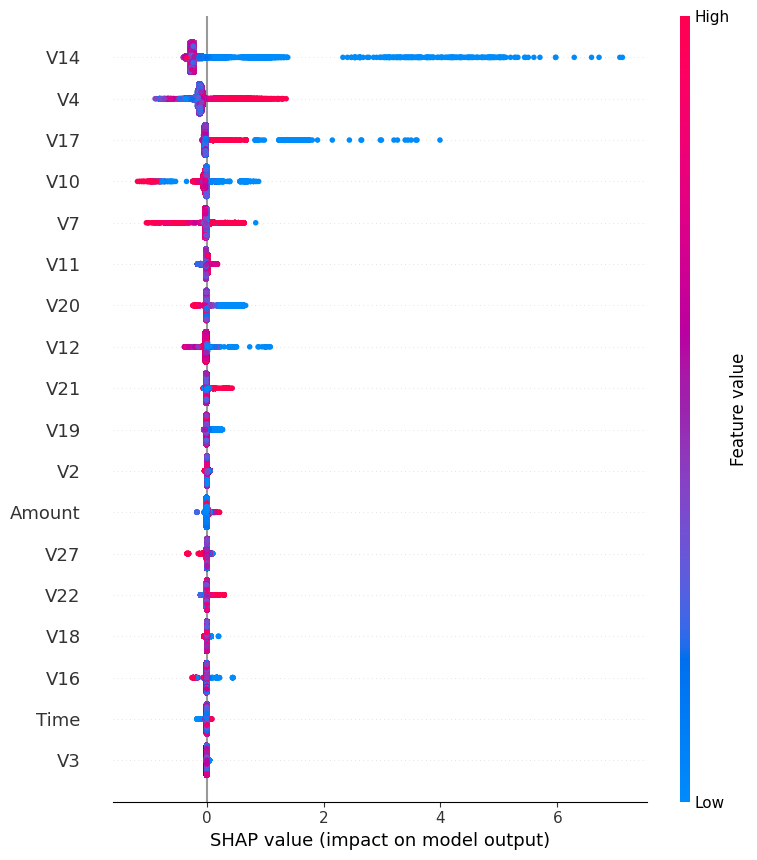

In [39]:
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score

# separating features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# splitting the data into training (80%) and test (20%) sets while preserving class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# defining a small parameter grid for tuning XGBoost
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [3, 6],
    "learning_rate": [0.1, 0.01],
    "subsample": [0.8, 1.0]
}

# using average precision as the scoring metric, appropriate for imbalanced data
avg_prec_scorer = make_scorer(average_precision_score, needs_proba=True)

# setting up cross-validation with StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# initializing the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# running GridSearchCV to tune hyper-parameters on the training set
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=avg_prec_scorer,
                           cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (Average Precision):", grid_search.best_score_)

# using the best model obtained from tuning for SHAP analysis on the test set
best_model = grid_search.best_estimator_

# creating a SHAP Explainer and compute SHAP values on the test set
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# plotting a SHAP summary of the feature importances
shap.summary_plot(shap_values, X_test, max_display=len(X_test.columns)-1)


**V14 is the Most Important Feature**
- V14 has the highest impact on model output, meaning it plays the most significant role in predicting fraud.

- Higher absolute SHAP values indicate stronger influence on the model's decision.

- The color gradiant shows that low values of V14 (blue) push predictions towards fraud (right), while high values (red) increase non-fraud probability (left).

**Other Key Features (V4, V12, V10) Also Have High Importance**

- V4, V12, and V10 follow V14 in importance, meaning they contribute strongly to separating between fraud and non-fraud.

- Features like Amount and Time appear mid-range, suggesting they play a moderate role but are not as dominant as PCA-transformed variables.

- Amount has a balanced spread of SHAP values, meaning its contribution varies between fraud and non-fraud cases.

**Features Lower in the List Have Little to No Impact**

- Features like V28, V18, and V6 HAVE much smaller SHAP values, meaning they contribute less to fraud classification.

- This suggests these features could be considered for removal.

**One thing worth considering is the following**

- The models struggle at predicting the fraud class more than anything.

- From the plot it can be notices that there are some features that possess low importance yet deviate more towards the fraud class.

- Features V17, V20, V22 and V13 in particular exhibit this (in that order of deviation).

- Therefore, it is concluded that these features should be retained.

**Describing Each Feature**

- V14
  - Blue (low) → Right (fraud), Red (high) → Left (non-fraud).
 - Low V14 increases fraud probability, high V14 predicts non-fraud.
- V4
  - Blue (low) → Left (Non-fraud), Red (high) → Right (fraud).
  - High V4 increases likelihood of fraud.
- V17
  - Blue (low) → Right (fraud), with some Red (high) on right side.
  - Low V17 values associated with fraud.
- V10
  - Red (high) → Left (non-fraud), Blue (low) → Right (fraud).
  - Low V10 increases fraud likelihood.
- V7
  - Red (high values) on both sides.
  - Weak decider between fraud and non-fraud class.
- V11
  - Red (high) → Right (fraud), Blue (low) → Left (non-fraud).
  - Higher V11 values tied to fraud.
- V20
  - Mostly Blue (low) on the right side (fraud).
  - Low V20 values lean more towards fraud.
- V12
  - Red (high) → Left (non-fraud), Blue (low) → Right (fraud).
  - Low V12 pushes towards fraud prediction.
- V19
  - Blue (low) → Right (fraud).
  - Low V19 linked to fraud.
- V21
  - Red (high) → Right (fraud), Blue (low) → Left (non-fraud).
  - Though somewhat jumbled, somewhat weak decider.
- V13
  - Mixed distribution, no clear pattern
- Amount
  - Mixed distribution, no clear pattern
- V27
  - Red (high) → Left (non-fraud)
  - High V27 leans towards non-fraud
- V22
  - Red (high) → Right (fraud)
  - High V22 leans towards fraud
-  V16
  - Somewhat mixed up, but mostly Blue (low) → Right (fraud), Red (high) → Left (non-fraud)
  - Mediocre decider between fraud and non-fraud.
- V26
  - Blue (low) on both sides with a mix of red and blue on the left side (non-fraud).
  - Weak decider between fraud and non-fraud.
- V24
  - Mixed distribution.
  - Low effect, unclear pattern, weak decider.

- Features V2, V9, V6, V8, V15, V28, V3, V18, Time, V5, V23, V1, V25. All these features have no-clear distribution on the SHAP plot, however based on this as well as the results from the Feature Importance Scores using RandomForestClassifier, the following actionable is derived:

-> Derived Actionable: Drop Features V1, V5, V6, V8, V13, V15, V23, V24, V25, V26, and V28.

## **1.4. Correlation Heatmap to Identify Redundant Features**


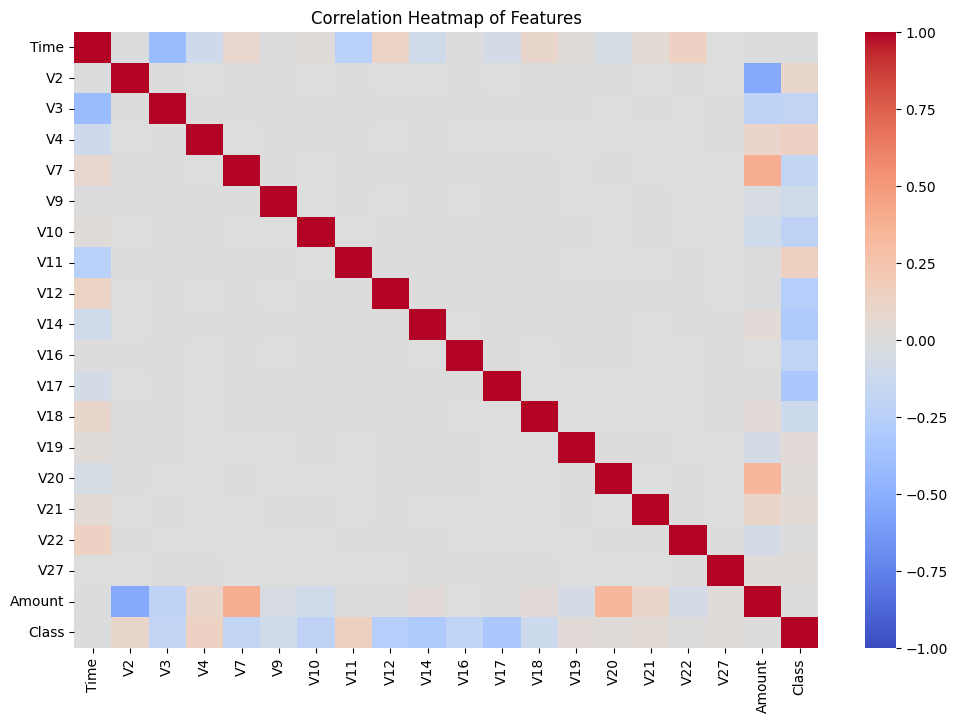

In [40]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Features")
plt.show()


- Since the dataset is PCA-transformed we see a light gray background which suggests that most features do not exhibit strong correlation with each other (No Correlation).

- Some PCA features show weak correlations (shown by faint blue and orange spots)

- The Time and Amount columns seem to show minor correlations with a few PCA features but nothing extreme.


## **1.5. Outlier Detection and Handling (For Time and Amount Column)**


### Box Plots & Interquartile Method for Outlier Detection

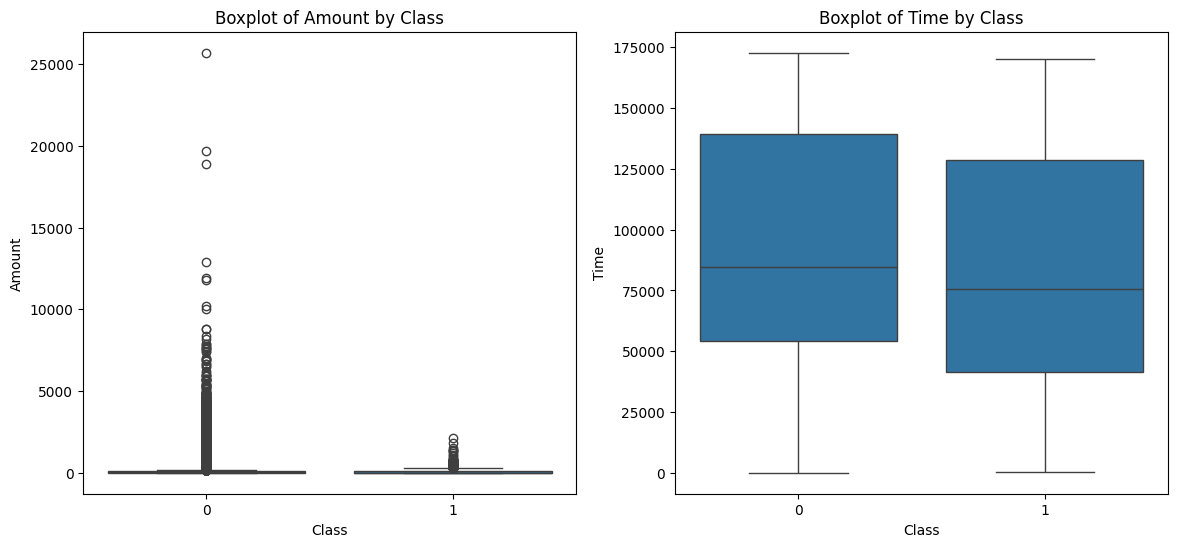

In [41]:
# outlier detection by plotting box plotss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Boxplot of Amount by Class")

plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Time', data=df)
plt.title("Boxplot of Time by Class")
plt.show()

**The Amount Column:**

The boxplot shows a large number of outliers in the Amount Column for both classes, particularly for the non-fraud class. This could also be discerned from observing the Amount column's histogram which was highly skewed.

Since the Amount column is highly skewed with extreme values, a log transformation should be applied.

**The Time Column:**

The Time Column does not show any significant difference between fraud and non-fraud transactions, it might not contribute much to classification, therefore it should likely be dropped.

If not, it can be normalized to ensure consistent scaling.

**-> Derived Actionable: Apply log transformation to Amount Column (After that the Amount column is Normalized).**


### Interquartile Method (IQR) For Outlier Detection

In [5]:
# detecting outliers using IQR
for column in ['Amount', 'Time']:  # Analyze 'Amount' and 'Time'
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Define the 'outliers' variable for the current column
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

  # Check fraud cases among outliers
  fraud_outliers = outliers[outliers['Class'] == 1]
  print(f"Outliers in {column}: {len(outliers)}")
  print(f"Fraud cases among outliers in {column}: {len(fraud_outliers)}")

Outliers in Amount: 31904
Fraud cases among outliers in Amount: 91
Outliers in Time: 0
Fraud cases among outliers in Time: 0


This output shows 31904 rows flagged as outliers in the Amount column based on the IQR method.

These outliers are transactions with amounts significantly higher than most other transactions (e.g. exceeding the upper whisker in the boxplot above)


For the time column, there is not outlier-specific action needed.

## **1.6. Visualizing the Class Imbalance**

Percentage of Fraud (Class==1): 99.82725143693798%
Percentage of Non-Fraud (Class==0): 0.1727485630620034%


<ipython-input-6-6d047aac2311>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  class_num = pd.value_counts(df["Class"], sort=True)


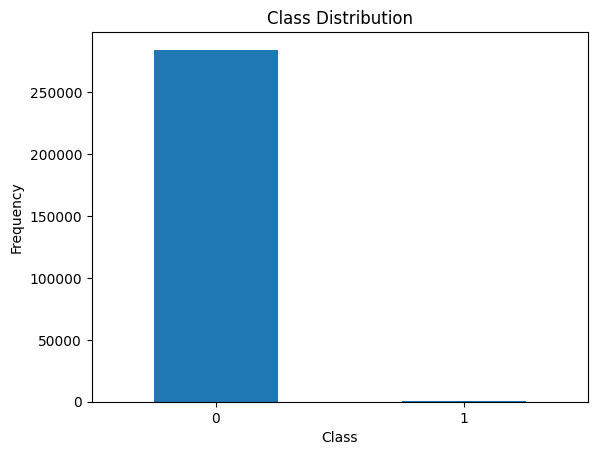

In [6]:
# visualizing the split between fraud and non-fraud class
class_num = pd.value_counts(df["Class"], sort=True)
class_num.plot(kind="bar", rot=0)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

# checking the percentage of fraud and non-fraud instances
print(f"Percentage of Fraud (Class==1): {df['Class'].value_counts()[0]/len(df) * 100}%")
print(f"Percentage of Non-Fraud (Class==0): {df['Class'].value_counts()[1]/len(df) * 100}%")

The bar chart above shows that fraud class accounts for 492 cases out of the total 284,807 transactions (Indicating a major class imbalance)

Only 0.173% of the dataset contains cases of fraud, while 99.827% is not fraud (values may vary to a few d.p). This means the dataset is heavily skewed/imbalanced and that will need to be dealt with.

**-> Derived Actionable: Oversample the Fraud class and/or undersample the Non-fraud class. Possibly use SMOTE or ADASYN.**

In [7]:
# compute statistical summary
statistical_summary = df.describe()

# display the summary
pd.set_option("display.float_format", "{:.2f}".format)  # Optional: Format decimal places
print(statistical_summary)

           Time        V1        V2        V3        V4        V5        V6  \
count 284807.00 284807.00 284807.00 284807.00 284807.00 284807.00 284807.00   
mean   94813.86      0.00      0.00     -0.00      0.00      0.00      0.00   
std    47488.15      1.96      1.65      1.52      1.42      1.38      1.33   
min        0.00    -56.41    -72.72    -48.33     -5.68   -113.74    -26.16   
25%    54201.50     -0.92     -0.60     -0.89     -0.85     -0.69     -0.77   
50%    84692.00      0.02      0.07      0.18     -0.02     -0.05     -0.27   
75%   139320.50      1.32      0.80      1.03      0.74      0.61      0.40   
max   172792.00      2.45     22.06      9.38     16.88     34.80     73.30   

             V7        V8        V9  ...       V21       V22       V23  \
count 284807.00 284807.00 284807.00  ... 284807.00 284807.00 284807.00   
mean      -0.00      0.00     -0.00  ...      0.00     -0.00      0.00   
std        1.24      1.19      1.10  ...      0.73      0.73      

In [8]:
# overall descriptive statistics same as df.describe()
overall_summary = df.describe()
print("\n===== Overall Summary (all rows) =====")
print(overall_summary)


# descriptive statistics separately for each class (count, mean, std, min, median, max)
summary_by_class = (
    df.groupby("Class")
      .agg(["count", "mean", "std", "min", "median", "max"])
)
print("\n===== Summary by Class (0 = non‑fraud, 1 = fraud) =====")
print(summary_by_class)

# skewness and kurtosis for every feature
skew_kurt = pd.DataFrame({
    "skew": df.skew(),
    "kurtosis": df.kurt()
})
print("\n===== Skewness and Kurtosis =====")
print(skew_kurt)

# checking missing values
missing = df.isnull().sum()
print("\n===== Missing‑Value Count per Column =====")
print(missing[missing > 0] if missing.sum() else "No missing values found.")



===== Overall Summary (all rows) =====
           Time        V1        V2        V3        V4        V5        V6  \
count 284807.00 284807.00 284807.00 284807.00 284807.00 284807.00 284807.00   
mean   94813.86      0.00      0.00     -0.00      0.00      0.00      0.00   
std    47488.15      1.96      1.65      1.52      1.42      1.38      1.33   
min        0.00    -56.41    -72.72    -48.33     -5.68   -113.74    -26.16   
25%    54201.50     -0.92     -0.60     -0.89     -0.85     -0.69     -0.77   
50%    84692.00      0.02      0.07      0.18     -0.02     -0.05     -0.27   
75%   139320.50      1.32      0.80      1.03      0.74      0.61      0.40   
max   172792.00      2.45     22.06      9.38     16.88     34.80     73.30   

             V7        V8        V9  ...       V21       V22       V23  \
count 284807.00 284807.00 284807.00  ... 284807.00 284807.00 284807.00   
mean      -0.00      0.00     -0.00  ...      0.00     -0.00      0.00   
std        1.24      1.19 

PCA components (V1 - V28)
- Already centred and scaled by the transformation, so no extra standardisation is needed.
- A few components show heavy tails, so robust models remain a sensible choice.

Amount
- Strongly right-skewed: most transactions are small, but a handful are very large.
- High spread confirms why a log transformation will be applied.

Time
- Spans the full two-day window of the dataset and sits on a much larger scale than the PCA features.
- Should be z-standardised (or possibly dropped) to keep the feature set on a comparable scale.

Class imbalance
- Fraud cases make up a tiny fraction of the data, reinforcing the need for resampling or class-weighted learning and for metrics such as precision-recall AUC.

Data completeness
- No missing values were detected, so no imputation step is required.

Fraud vs non-fraud contrasts
- Fraud transactions tend to occur slightly earlier in the time window and involve somewhat higher amounts.
- Several PCA features show different averages between the two classes, indicating useful separation.

**-> Derived Actionable: Log transform Amount Column and Standardize Time Column**

## **1.7. Transaction Amount Analysis**

Exploring if there are distinct patterns in Amount for fraud and non-fraud transactions by visualizing and calculating summary statistics.

For example, fraud might occur more often with lower or higher amounts.




In [9]:
# pull amount values directly from the original dataframe
fraud_amounts     = df.loc[df["Class"] == 1, "Amount"]
nonfraud_amounts  = df.loc[df["Class"] == 0, "Amount"]

plt.figure(figsize=(10, 5))
sns.kdeplot(fraud_amounts,    label="Fraud",     fill=True)
sns.kdeplot(nonfraud_amounts, label="Non-Fraud", fill=True)

plt.title("Transaction Amounts (Fraud vs. Non-Fraud)")
plt.xlabel("Amount")
plt.legend()
plt.show()


NameError: name 'sns' is not defined

<Figure size 1000x500 with 0 Axes>

*  Both Fraud and Non-fraud transaction amounts are heavily skewed toward smaller values.

* Fraud transactions (blue line) appear concentrated around lower values (close to 0), while Non-Fraud transactions (orange line) has a broader spread into larger amounts but still concentrated near 0.

  *  There are extreme values, especially for Non-Fraud transactions, where the curve extends towards 25,000.

* There is significant overlap between Fraud and Non-Fraud classes at lower transaction amounts, which aligns with the summary statistics and earlier histogram analysis.

## **1.8. Explained Variance Analysis for PCA Transformed Features**

Since the features V1 to V28 are already PCA-transformed and the explained variance ratios were not saved or provided during the PCA process, there is no direct way to calculate the explained variance because the original PCA model and data are not available.

The alternatives such as measuring feature importance of the fraud and non-fraud overlap for each feature were measured above to compensate for the lack of analysis on explained variance.



## **1.9. Summing Up Actionable Steps for Data Preprocessing**

### Actionables for Data Pre-processing

- **Drop low-value features**: Remove V1, V5, V6, V8, V13, V15, V23, V24, V25, V26, and V28 before any split

- **Stratified split**: 70/30 train/test with stratify=Class to preserve fraud rate  

- **Log‐transform Amount**: Apply np.log1p() on training & test subsets  

- **Pipeline‐only scaling**: Include StandardScaler on Amount inside ColumnTransformer (no manual fit)

- **Hybrid sampling**: ADASYN  + RandomUnderSampler in a FunctionSampler step inside the CV pipeline  

- **Embed in ImbPipeline**: Use the sequence  
  1. hybrid_sampling (ADASYN + undersampling)  
  2. scaler (StandardScaler on Amount)  
  3. classifier (chosen model)  
  inside each pipeline so resampling and scaling run fresh on every CV fold










# **2. Data Preprocessing**

In this step we will apply the data preprocessing actionable steps derived from our data analysis above.

### **Actionable Step 1 - Drop Irrelvant Features**

In [10]:
# dropping irrelevant features
df = df.drop(columns=['V1', 'V5', 'V6', 'V8', 'V13', 'V15', 'V23', 'V24', 'V25', 'V26', 'V28'])

### **Actionable Step #2 - Splitting Dataset into training, validation and test sets**

In [11]:
# splitting data set into training, validation and testing
# 0-70%: training set
# 70-100% of Dataset: testing srt
training_set, testing_set = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Class'])


### **Actionable Step #3 - Log Transform the Amount Column**


In [12]:
# log transformation for amount
for subset in [training_set, testing_set]:
    subset['Amount'] = np.log1p(subset['Amount'])  # Use log1p to handle zeros safely


In [13]:
# compute statistical summary for the trainin set
statistical_summary = training_set.describe()

# display the summary
pd.set_option("display.float_format", "{:.2f}".format)
print(statistical_summary)

           Time        V2        V3        V4        V7        V9       V10  \
count 199364.00 199364.00 199364.00 199364.00 199364.00 199364.00 199364.00   
mean   94898.21     -0.00     -0.00      0.00     -0.00      0.00      0.00   
std    47489.93      1.66      1.52      1.42      1.25      1.10      1.09   
min        0.00    -72.72    -48.33     -5.68    -43.56    -13.43    -24.59   
25%    54253.75     -0.60     -0.89     -0.85     -0.55     -0.64     -0.53   
50%    84845.50      0.06      0.18     -0.02      0.04     -0.05     -0.09   
75%   139365.00      0.80      1.03      0.74      0.57      0.60      0.46   
max   172792.00     22.06      9.38     16.88    120.59     15.59     23.75   

            V11       V12       V14       V16       V17       V18       V19  \
count 199364.00 199364.00 199364.00 199364.00 199364.00 199364.00 199364.00   
mean      -0.00      0.00     -0.00     -0.00      0.00     -0.00      0.00   
std        1.02      1.00      0.96      0.88      

#**3. K-Fold Cross Validation & Hyper Parameter Tuning**

K-Fold Cross Validation is performed at this stage as the first 3 preprocessing steps preceding it are:

- Dropping Irrelevant Features
- Creating the Train-Test Split
- Log Transformations of the Amount Column


K-Fold CV has to take place before the training set undergoes Normalization and SMOTE, as these preprocessing steps need to take place inside the cross-validation loop. This is such that each fold's training portion has its own preprocessing applied without knowledge of the validation portion.



## **Setting up the Train and Test Sets for K-Fold Cross Validation**



In [14]:
# Define features/targets (DO NOT SCALE OR OVERSAMPLE YET)
X_train = training_set.drop(columns=['Class'])
y_train = training_set['Class']
X_test = testing_set.drop(columns=['Class'])
y_test = testing_set['Class']

## **Imports Needed**


In [15]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, make_scorer, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report

## **3.1. Defining Hyper-Parameters for each Model**

This defines the search space for hyper-parameter tuning for each learning model.

- **Naive Bayes** has no tunable hyper-parameters, so we leave it as an empty dictionary.

- **Logistic Regression**: We tune:  
  - *C:* controls regularization strength  
  - *max_iter:* defines the maximum number of iterations for convergence  
  - *solver:* selects the optimization algorithm

- **Random Forest**: We tune multiple parameters such as:  
  - *n_estimators:* the number of trees in the forest  
  - *max_depth:* the maximum depth of each tree  
  - *min_samples_split:* the minimum number of samples required to split an internal node  
  - *min_samples_leaf:* the minimum number of samples required to be at a leaf node  
  - *max_features:* the number of features to consider when looking for the best split

- **Support Vector Machines (SVM)**: We tune:  
  - *C:* controls regularization  
  - *kernel:* specifies the kernel type (linear or RBF)  
  - *gamma:* defines how far the influence of a single training example reaches  
  - *class_weight:* balances the class weights automatically

- **XGBoost**: We tune:  
  - *n_estimators:* the number of boosting rounds  
  - *max_depth:* the maximum tree depth for base learners  
  - *learning_rate:* the step size shrinkage used in updates  
  - *subsample:* the fraction of observations to subsample each tree  
  - *colsample_bytree:* the fraction of features to subsample each tree

- **Balanced Random Forest**: We tune:  
  - *n_estimators:* the number of trees in the ensemble  
  - *max_depth:* the maximum depth of each tree  
  - *min_samples_split:* the minimum number of samples required to split an internal node  
  - *min_samples_leaf:* the minimum number of samples required to be at a leaf node  
  - *bootstrap:* whether bootstrap samples are used when building trees

- **LightGBM**: We tune:  
  - *n_estimators:* the number of boosting rounds  
  - *num_leaves:* the maximum number of leaves in one tree  
  - *learning_rate:* the step size shrinkage in each boosting step  
  - *max_depth:* the maximum depth of each tree (–1 means no limit)  
  - *subsample:* the fraction of data to sample for each iteration  
  - *colsample_bytree:* the fraction of features to sample for each iteration  
  - *scale_pos_weight:* the weight balancing for the positive (fraud) class

In [16]:
models = {
    "Naive Bayes": GaussianNB(var_smoothing=1e-3),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Support Vector Machines": SVC(kernel='linear', class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "Balanced Random Forest": BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=3,
    class_weight="balanced_subsample",
    bootstrap=True,
    random_state=42
),
    "LightGBM": LGBMClassifier(objective="binary", random_state=42)
}

# Define Scoring Metrics for GridSearchCV
scoring = {
    "Precision": make_scorer(precision_score, pos_label=1),
    "Recall": make_scorer(recall_score, pos_label=1),
    "F1-Score": make_scorer(f1_score, pos_label=1),
}

## **3.2. Defining Pipelines for Each Model**

- ColumnTransformer ensures that only the "Amount" and "Time" columns are standardized, leaving PCA-transforme features unchanges.

- Pipeline are defined to steamline training:
  - scaler: Standardizes "Amount" and "Time"
  - smote: Applies SMOTE inside cross-validation to balanmce fraud and non-fraud cases.
  - classifier: The machine learning model itself.

- Stratified K-Fold: is used for cross-validation to ensure each fold maintains the class imbalance distribution.

In [17]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from imblearn import FunctionSampler

# --- hybrid sampling function ---
def apply_hybrid_sampling(X, y):
  adasyn = ADASYN(sampling_strategy=0.2, random_state=42)
  rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

  X_resampled, y_resampled = adasyn.fit_resample(X, y)
  X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

  return X_resampled, y_resampled

hybrid_sampler = FunctionSampler(func=apply_hybrid_sampling, validate=False)

# functionsampler to apply the hybrid approach inside the cross-validation
hybrid_sampler = FunctionSampler(func=apply_hybrid_sampling, validate=False)

# defining standrd scaler for amoiunt feature
scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['Amount'])
    ], remainder='passthrough'
)

# defining pipelines for each model
pipelines = {}
for model_name, model in models.items():
  pipelines[model_name] = ImbPipeline([
    ("hybrid_sampling", hybrid_sampler),
    ("scaler", scaler),
    ("classifier", model)
  ])

# initiilzing statified kfold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## **3.3. Performing Hyper-Parameter Tuning with GridSearchCV**

GridSearchCV automates tuning by exhaustively searching specified hyper-parameter grids:

- For each model with a grid defined:  
  - It evaluates every combination  
  - Uses 5-fold stratified cross-validation to preserve the fraud/non-fraud ratio  
  - Scores each run by F1-score and picks the top set

- The selected “best” pipeline for each model is then applied to the held-out test split.

- Final performance is summarized with classification reports on precision, recall, F1 and AUPRC for fraud detection.


In [18]:
best_models = {}
best_params = {}

### **Naive Bayes**


In [19]:
# Define the parameter grid for Naive Bayes
nb_param_grid = {
    "classifier__var_smoothing": [1e-9, 1e-6, 1e-3, 1e-1]
}

# Run GridSearchCV for Naive Bayes
grid_search_nb = GridSearchCV(
    pipelines["Naive Bayes"],
    nb_param_grid,
    cv=kf,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_search_nb.fit(X_train, y_train)
best_models["Naive Bayes"] = grid_search_nb.best_estimator_
best_params["Naive Bayes"] = grid_search_nb.best_params_

print(f"Best Parameters for Naive Bayes: {grid_search_nb.best_params_}\n")

# --- Evaluate on Test Set ---
y_pred_nb = best_models["Naive Bayes"].predict(X_test)
print("\nNaive Bayes Performance on Test Set:")
print(classification_report(y_test, y_pred_nb))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters for Naive Bayes: {'classifier__var_smoothing': 1e-09}


Naive Bayes Performance on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.22      0.80      0.34       148

    accuracy                           0.99     85443
   macro avg       0.61      0.90      0.67     85443
weighted avg       1.00      0.99      1.00     85443



### **Logistic Regression (Hyper-parameter Tuning)**

In [21]:
from sklearn.model_selection import GridSearchCV

print("Running GridSearchCV for Logistic Regression...\n")

# Parameters for Logistic Regression
lr_param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__max_iter": [100, 500, 1000],
    "classifier__solver": ["liblinear", "saga"]
}

lr_pipeline = pipelines["Logistic Regression"]
grid_search_lr = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=kf,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search_lr.fit(X_train, y_train)

# Store the best model and parameters
best_models["Logistic Regression"] = grid_search_lr.best_estimator_
best_params["Logistic Regression"] = grid_search_lr.best_params_

print(f"Best Parameters for Logistic Regression: {grid_search_lr.best_params_}\n")

# --- Evaluate on Test Set ---
y_pred_lr = best_models["Logistic Regression"].predict(X_test)
print("\nLogistic Regression Performance on Test Set:")
print(classification_report(y_test, y_pred_lr))


Running GridSearchCV for Logistic Regression...

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters for Logistic Regression: {'classifier__C': 0.01, 'classifier__max_iter': 500, 'classifier__solver': 'saga'}


Logistic Regression Performance on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.27      0.55      0.36       148

    accuracy                           1.00     85443
   macro avg       0.64      0.77      0.68     85443
weighted avg       1.00      1.00      1.00     85443



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### **Random Forest (Hyper-parameter Tuning)**

In [22]:
print("Running GridSearchCV for Random Forest...\n")

rf_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth":    [15, None],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf":  [1, 2],
    "classifier__max_features": ["sqrt"]
}

rf_pipeline = pipelines["Random Forest"]
grid_search_rf = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=kf,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search_rf.fit(X_train, y_train)

# Store the best model and parameters
best_models["Random Forest"] = grid_search_rf.best_estimator_
best_params["Random Forest"] = grid_search_rf.best_params_

print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}\n")

# --- Evaluate on Test Set ---
y_pred_rf = best_models["Random Forest"].predict(X_test)
print("\nRandom Forest Performance on Test Set:")
print(classification_report(y_test, y_pred_rf))


Running GridSearchCV for Random Forest...

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters for Random Forest: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


Random Forest Performance on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.78      0.81      0.79       148

    accuracy                           1.00     85443
   macro avg       0.89      0.91      0.90     85443
weighted avg       1.00      1.00      1.00     85443



### **Support Vector Machines (Hyper-parameter Tuning)**

In [23]:
'''print("Running GridSearchCV for Support Vector Machines...\n")

svm_param_grid = {
    "classifier__C": [0.1, 1, 10, 100],
    "classifier__kernel": ["linear", "rbf"],
    "classifier__gamma": ["scale", "auto"],
    "classifier__class_weight": [None, "balanced"]
}

svm_pipeline = pipelines["Support Vector Machines"]
grid_search_svm = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    cv=kf,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search_svm.fit(X_train, y_train)

# Store the best model and parameters
best_models["Support Vector Machines"] = grid_search_svm.best_estimator_
best_params["Support Vector Machines"] = grid_search_svm.best_params_

print(f"Best Parameters for Support Vector Machines: {grid_search_svm.best_params_}\n")

# --- Evaluate on Test Set ---
y_pred_svm = best_models["Support Vector Machines"].predict(X_test)
print("\nSupport Vector Machines Performance on Test Set:")
print(classification_report(y_test, y_pred_svm))


Running GridSearchCV for Support Vector Machines...

Fitting 5 folds for each of 32 candidates, totalling 160 fits


KeyboardInterrupt: 

### **XGBoost (Hyper-parameter Tuning)**

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:41:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


XGBoost Performance on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.72      0.82      0.77       148

    accuracy                           1.00     85443
   macro avg       0.86      0.91      0.88     85443
weighted avg       1.00      1.00      1.00     85443



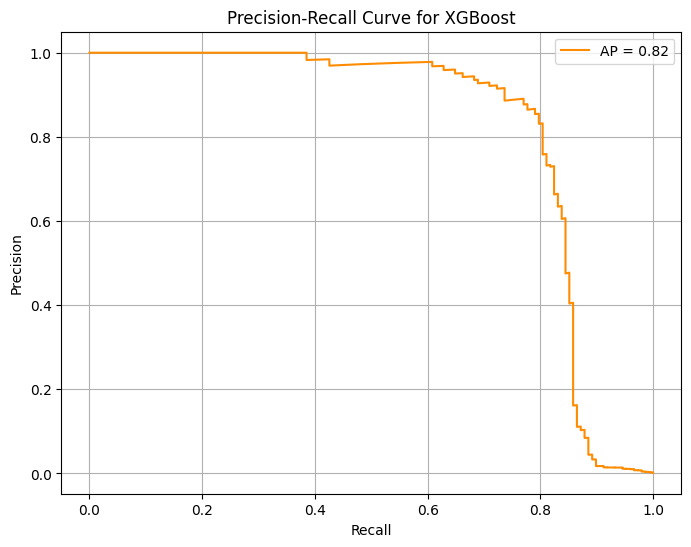

In [24]:
from xgboost import XGBClassifier

# Define the parameter grid for XGBoost
xgb_param_grid = {
    "classifier__n_estimators": [50, 100, 200],  # Number of trees
    "classifier__max_depth": [3, 6, 9],  # Depth of trees
    "classifier__learning_rate": [0.01, 0.1, 0.2],  # Step size shrinkage
    "classifier__subsample": [0.8, 1.0],  # Fraction of samples used for training each tree
    "classifier__colsample_bytree": [0.8, 1.0]  # Fraction of features used for each tree
}

# Define XGBoost Pipeline
pipelines["XGBoost"] = ImbPipeline([
    ("scaler", scaler),  # Apply scaling to Amount (already defined)
    ("hybrid_sampling", hybrid_sampler),  # Apply ADASYN + Undersampling
    ("classifier", models["XGBoost"])  # XGBoost model
])

# Run GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(
  pipelines["XGBoost"],
  xgb_param_grid,
  cv=kf,
  scoring="f1",
  n_jobs=-1,
  verbose=1
)

grid_search_xgb.fit(X_train, y_train)
best_models["XGBoost"] = grid_search_xgb.best_estimator_
best_params["XGBoost"] = grid_search_xgb.best_params_

print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}\n")

# --- Evaluate on Test Set ---
y_pred_xgb = best_models["XGBoost"].predict(X_test)
print("\nXGBoost Performance on Test Set:")
print(classification_report(y_test, y_pred_xgb))

# --- Precision-Recall Curve ---
# Get predicted probabilities for the positive class (fraud)
y_scores_xgb = best_models["XGBoost"].predict_proba(X_test)[:, 1]

# Compute precision-recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_test, y_scores_xgb)
avg_precision = average_precision_score(y_test, y_scores_xgb)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for XGBoost')
plt.legend()
plt.grid()
plt.show()


### **LightGBM (Hyper-parameter Tuning)**

Running GridSearchCV for LightGBM...

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 39744, number of negative: 79488
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 119232, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Best Parameters for LightGBM: {'classifier__boosting_type': 'gbdt', 'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': -1, 'classifier__n_estimators': 200, 'classifier__num_leaves': 50, 'classifier__scale_pos_weight': 10, 'classifier__subsample': 1.0}



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Performance on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.73      0.81      0.77       148

    accuracy                           1.00     85443
   macro avg       0.87      0.91      0.88     85443
weighted avg       1.00      1.00      1.00     85443



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


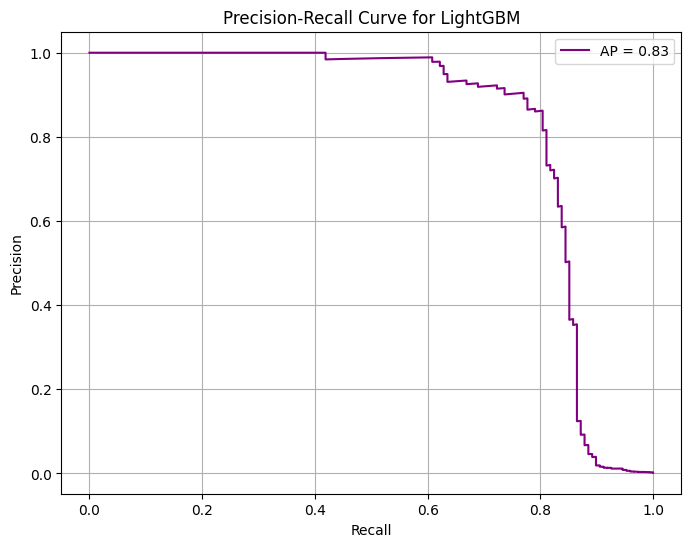

In [25]:
from lightgbm import LGBMClassifier

print("Running GridSearchCV for LightGBM...\n")

# Define the hyperparameter grid for LightGBM
lgbm_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [-1],  # -1 allows automatic depth selection
    "classifier__learning_rate": [0.05, 0.1],  # Keeps it small but not too slow
    "classifier__num_leaves": [31, 50],  # Default setting (optimized for speed)
    "classifier__boosting_type": ["gbdt"],  # Only use GBDT (fastest and best generalization)
    "classifier__subsample": [1.0],  # Use full data for training (avoid unnecessary complexity)
    "classifier__colsample_bytree": [1.0],  # Use all features in each boosting round
    "classifier__scale_pos_weight": [10, 25, 50, 100]  # Helps balance fraud class
}

# Define LightGBM Pipeline
pipelines["LightGBM"] = ImbPipeline([
    ("scaler", scaler),  # Apply scaling to Amount (already defined)
    ("hybrid_sampling", hybrid_sampler),  # Apply ADASYN + Undersampling
    ("classifier", models["LightGBM"])  # LightGBM model
])

# Run GridSearchCV for LightGBM
grid_search_lgbm = GridSearchCV(
    pipelines["LightGBM"],
    lgbm_param_grid,
    cv=kf,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search_lgbm.fit(X_train, y_train)

# Store the best model and parameters
best_models["LightGBM"] = grid_search_lgbm.best_estimator_
best_params["LightGBM"] = grid_search_lgbm.best_params_

print(f"Best Parameters for LightGBM: {grid_search_lgbm.best_params_}\n")

# --- Evaluate on Test Set ---
y_pred_lgbm = best_models["LightGBM"].predict(X_test)
print("\nLightGBM Performance on Test Set:")
print(classification_report(y_test, y_pred_lgbm))

# --- Precision-Recall Curve ---
# Get predicted probabilities for the positive class (fraud)
y_scores_lgbm = best_models["LightGBM"].predict_proba(X_test)[:, 1]

# Compute precision-recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_test, y_scores_lgbm)
avg_precision = average_precision_score(y_test, y_scores_lgbm)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for LightGBM')
plt.legend()
plt.grid()
plt.show()


### **BalancedRandomForest (Hyper-parameter Tuning)**

In [26]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Define the parameter grid for Balanced Random Forest
brf_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [5, 10],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__bootstrap": [True]
}

# Define Balanced Random Forest Pipeline
pipelines["Balanced Random Forest"] = ImbPipeline([
    ("scaler", scaler),  # Apply scaling to Amount (already defined)
    ("hybrid_sampling", hybrid_sampler),  # Apply ADASYN + Undersampling
    ("classifier", models["Balanced Random Forest"])  # Balanced Random Forest model
])

# Run GridSearchCV for Balanced Random Forest
grid_search_brf = GridSearchCV(
    pipelines["Balanced Random Forest"],
    brf_param_grid,
    cv=kf,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_search_brf.fit(X_train, y_train)
best_models["Balanced Random Forest"] = grid_search_brf.best_estimator_
best_params["Balanced Random Forest"] = grid_search_brf.best_params_

print(f"Best Parameters for Balanced Random Forest: {grid_search_brf.best_params_}\n")

# --- Evaluate on Test Set ---
y_pred_brf = best_models["Balanced Random Forest"].predict(X_test)
print("\nBalanced Random Forest Performance on Test Set:")
print(classification_report(y_test, y_pred_brf))


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters for Balanced Random Forest: {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}


Balanced Random Forest Performance on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.62      0.84      0.71       148

    accuracy                           1.00     85443
   macro avg       0.81      0.92      0.86     85443
weighted avg       1.00      1.00      1.00     85443



## **3.4. Setting up Tuned Models (Best Hyper-Parameters)**

Instead of re-running all grid searches, this code rebuilds each pipeline using the optimal settings you found. For every model—Naive Bayes, Logistic Regression, Random Forest, XGBoost, LightGBM, and Balanced Random Forest—the hybrid sampling and Amount scaler steps are included in the same order, and the classifier is initialized with its best hyper-parameters. Storing these ready-to-go pipelines in best_models (and their parameter dicts in best_params) lets you jump straight to test-set evaluation without repeating the tuning process.



In [27]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# --- Recreate best_models with tuned hyperparameters ---
'''best_models = {
    'Naive Bayes': ImbPipeline([
        ('hybrid_sampling', hybrid_sampler),
        ('scaler', scaler),
        ('classifier', GaussianNB(var_smoothing=1e-9))
    ]),
    'Logistic Regression': ImbPipeline([
        ('hybrid_sampling', hybrid_sampler),
        ('scaler', scaler),
        ('classifier', LogisticRegression(
            C=0.01, solver='saga', max_iter=500,
            class_weight='balanced', random_state=42))
    ]),
    'Random Forest': ImbPipeline([
        ('hybrid_sampling', hybrid_sampler),
        ('scaler', scaler),
        ('classifier', RandomForestClassifier(
            n_estimators=200, min_samples_split=5,
            min_samples_leaf=1, max_features='sqrt',
            class_weight='balanced', random_state=42))
    ]),
    'XGBoost': ImbPipeline([
        ('scaler', scaler),
        ('hybrid_sampling', hybrid_sampler),
        ('classifier', XGBClassifier(
            n_estimators=50, max_depth=9,
            learning_rate=0.01, subsample=1.0,
            colsample_bytree=0.8,
            use_label_encoder=False, eval_metric='logloss',
            random_state=42))
    ]),
    'LightGBM': ImbPipeline([
        ('scaler', scaler),
        ('hybrid_sampling', hybrid_sampler),
        ('classifier', LGBMClassifier(
            boosting_type='gbdt', n_estimators=200,
            num_leaves=50, learning_rate=0.1,
            subsample=1.0, colsample_bytree=1.0,
            scale_pos_weight=10, random_state=42))
    ]),
    'Balanced Random Forest': ImbPipeline([
        ('scaler', scaler),
        ('hybrid_sampling', hybrid_sampler),
        ('classifier', BalancedRandomForestClassifier(
            n_estimators=200, max_depth=20,
            min_samples_split=5, min_samples_leaf=1,
            bootstrap=True, class_weight='balanced_subsample',
            random_state=42))
    ]),
}

# --- Recreate best_params for easy reference ---
best_params = {
    'Naive Bayes': {
        'classifier__var_smoothing': 1e-9
    },
    'Logistic Regression': {
        'classifier__C': 0.01,
        'classifier__solver': 'saga',
        'classifier__max_iter': 500
    },
    'Random Forest': {
        'classifier__n_estimators': 200,
        'classifier__max_depth': None,
        'classifier__min_samples_split': 5,
        'classifier__min_samples_leaf': 1,
        'classifier__max_features': 'sqrt'
    },
    'XGBoost': {
        'classifier__n_estimators': 50,
        'classifier__max_depth': 9,
        'classifier__learning_rate': 0.01,
        'classifier__subsample': 1.0,
        'classifier__colsample_bytree': 0.8
    },
    'LightGBM': {
        'classifier__boosting_type': 'gbdt',
        'classifier__n_estimators': 200,
        'classifier__num_leaves': 50,
        'classifier__learning_rate': 0.1,
        'classifier__subsample': 1.0,
        'classifier__colsample_bytree': 1.0,
        'classifier__scale_pos_weight': 10
    },
    'Balanced Random Forest': {
        'classifier__n_estimators': 200,
        'classifier__max_depth': 20,
        'classifier__min_samples_split': 5,
        'classifier__min_samples_leaf': 1,
        'classifier__bootstrap': True
    }
}

SyntaxError: incomplete input (<ipython-input-27-74a44efac587>, line 10)

In [28]:
print(best_models)

{'Naive Bayes': Pipeline(steps=[('hybrid_sampling',
                 FunctionSampler(func=<function apply_hybrid_sampling at 0x7b36177723e0>,
                                 validate=False)),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Amount'])])),
                ('classifier', GaussianNB())]), 'Logistic Regression': Pipeline(steps=[('hybrid_sampling',
                 FunctionSampler(func=<function apply_hybrid_sampling at 0x7b36177723e0>,
                                 validate=False)),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Amount'])])),
                ('classifier',
                 LogisticRegression(C=0.01, class_weight='balanced

In [29]:
print(best_params)

{'Naive Bayes': {'classifier__var_smoothing': 1e-09}, 'Logistic Regression': {'classifier__C': 0.01, 'classifier__max_iter': 500, 'classifier__solver': 'saga'}, 'Random Forest': {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}, 'XGBoost': {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 9, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}, 'LightGBM': {'classifier__boosting_type': 'gbdt', 'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': -1, 'classifier__n_estimators': 200, 'classifier__num_leaves': 50, 'classifier__scale_pos_weight': 10, 'classifier__subsample': 1.0}, 'Balanced Random Forest': {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}}


In [30]:
for name, pipe in best_models.items():
    pipe.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:05:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 39744, number of negative: 79488
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 119232, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147


# **4. Final Run for all Models**


## **Naive Bayes**


=== Naive Bayes — Test-set performance ===
              precision    recall  f1-score   support

           0      1.000     0.995     0.997     85295
           1      0.219     0.797     0.343       148

    accuracy                          0.995     85443
   macro avg      0.609     0.896     0.670     85443
weighted avg      0.998     0.995     0.996     85443



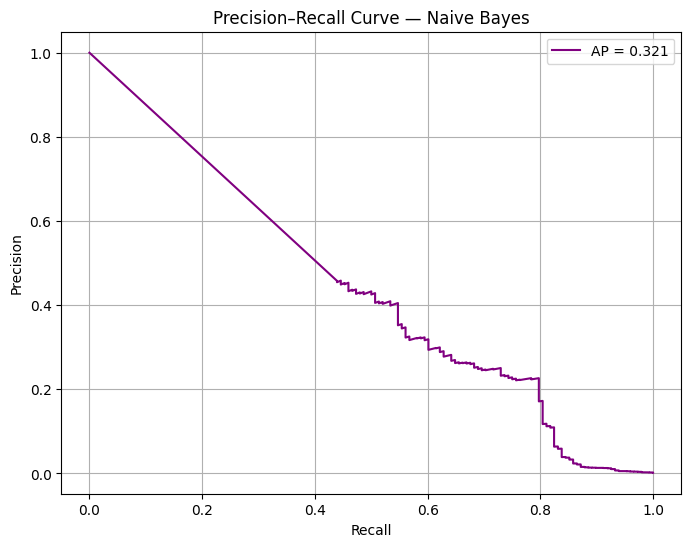

In [31]:
# === Final Test Evaluation: Naïve Bayes ===
model_name = "Naive Bayes"
model = best_models[model_name]

y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]

print(f"\n=== {model_name} — Test-set performance ===")
print(classification_report(y_test, y_pred, digits=3))

precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}", color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve — {model_name}")
plt.legend()
plt.grid(True)
plt.show()


## **Logistic Regression**


=== Logistic Regression — Test-set performance ===
              precision    recall  f1-score   support

           0      0.999     0.997     0.998     85295
           1      0.273     0.547     0.364       148

    accuracy                          0.997     85443
   macro avg      0.636     0.772     0.681     85443
weighted avg      0.998     0.997     0.997     85443



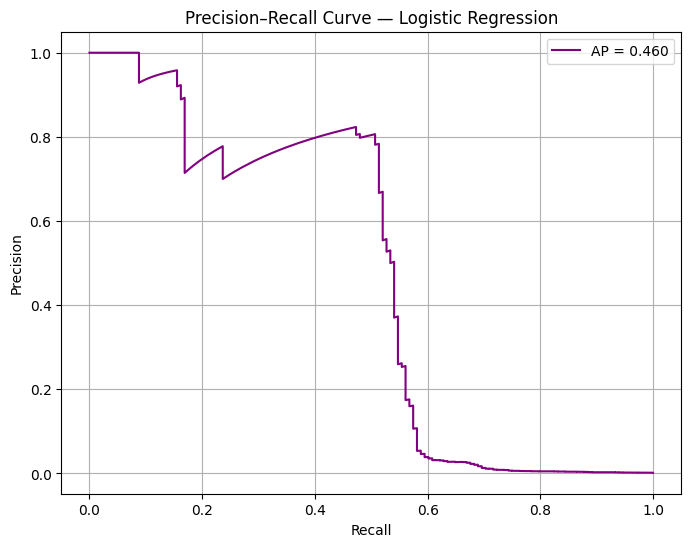

In [32]:
# === Final Test Evaluation: Logistic Regression ===
model_name = "Logistic Regression"
model = best_models[model_name]

y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]

print(f"\n=== {model_name} — Test-set performance ===")
print(classification_report(y_test, y_pred, digits=3))

precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}", color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve — {model_name}")
plt.legend()
plt.grid(True)
plt.show()


## **Random Forest**


=== Random Forest — Test-set performance ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     85295
           1      0.779     0.811     0.795       148

    accuracy                          0.999     85443
   macro avg      0.889     0.905     0.897     85443
weighted avg      0.999     0.999     0.999     85443



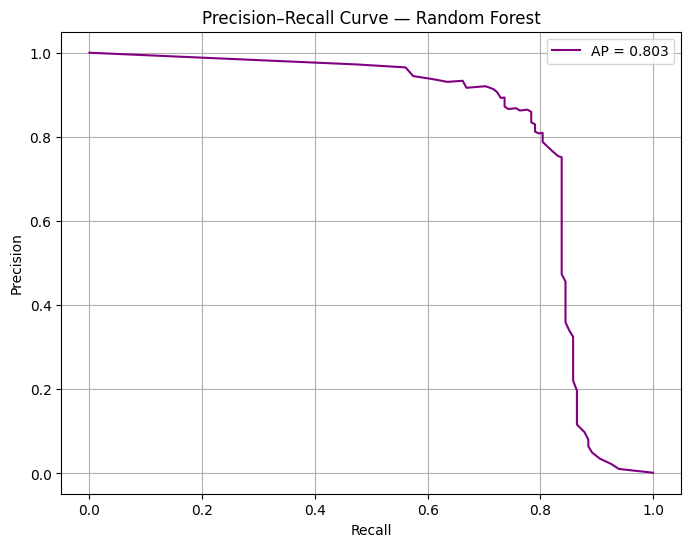

In [33]:
# === Final Test Evaluation: Random Forest ===
model_name = "Random Forest"
model = best_models[model_name]

y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]

print(f"\n=== {model_name} — Test-set performance ===")
print(classification_report(y_test, y_pred, digits=3))

precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}", color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve — {model_name}")
plt.legend()
plt.grid(True)
plt.show()


## **XGBoost**


=== XGBoost — Test-set performance ===
              precision    recall  f1-score   support

           0      1.000     0.999     1.000     85295
           1      0.722     0.824     0.770       148

    accuracy                          0.999     85443
   macro avg      0.861     0.912     0.885     85443
weighted avg      0.999     0.999     0.999     85443



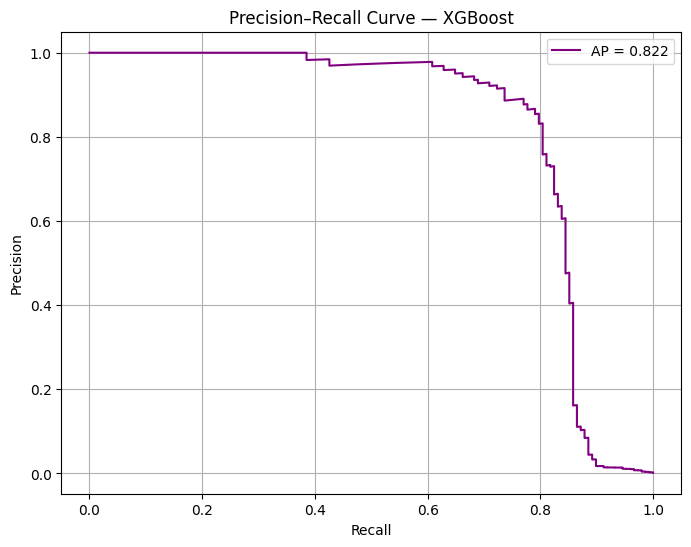

In [34]:
# === Final Test Evaluation: XGBoost ===
model_name = "XGBoost"
model = best_models[model_name]

y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]

print(f"\n=== {model_name} — Test-set performance ===")
print(classification_report(y_test, y_pred, digits=3))

precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}", color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve — {model_name}")
plt.legend()
plt.grid(True)
plt.show()


## **LightGBM**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== LightGBM — Test‑set performance ===
              precision    recall  f1-score   support

           0      1.000     0.999     1.000     85295
           1      0.732     0.811     0.769       148

    accuracy                          0.999     85443
   macro avg      0.866     0.905     0.884     85443
weighted avg      0.999     0.999     0.999     85443



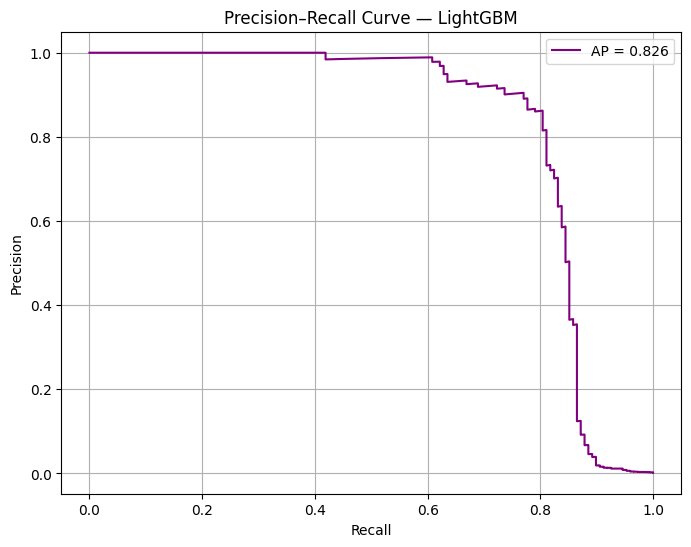

In [35]:
# ------------------------------------------------------------
# Final test‑set evaluation for a single tuned model
# ------------------------------------------------------------
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Choose the model you want to evaluate
model_name = "LightGBM"                 # <-- change to "XGBoost", "RandomForest", ...
model      = best_models[model_name]    # already refit by GridSearchCV

# Predict class labels and fraud probabilities on the test set
y_pred   = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]

# Print standard metrics
print(f"\n=== {model_name} — Test‑set performance ===")
print(classification_report(y_test, y_pred, digits=3))

# Precision–Recall curve and Average Precision (AUPRC)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}", color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve — {model_name}")
plt.legend()
plt.grid(True)
plt.show()

## **Balanced Random Forest**



=== Balanced Random Forest — Test-set performance ===
              precision    recall  f1-score   support

           0      1.000     0.999     0.999     85295
           1      0.617     0.838     0.711       148

    accuracy                          0.999     85443
   macro avg      0.808     0.918     0.855     85443
weighted avg      0.999     0.999     0.999     85443



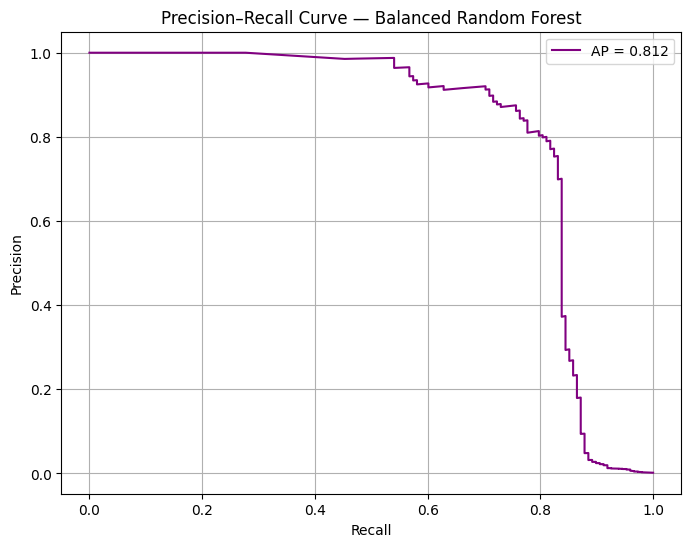

In [36]:
# === Final Test Evaluation: Balanced Random Forest ===
model_name = "Balanced Random Forest"
model = best_models[model_name]

y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]

print(f"\n=== {model_name} — Test-set performance ===")
print(classification_report(y_test, y_pred, digits=3))

precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}", color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve — {model_name}")
plt.legend()
plt.grid(True)
plt.show()


# **5. Analyzing Results (Models' Performance)**

- **Naïve Bayes**  
  Despite perfect majority-class accuracy, the fraud-class precision is only approximately 22%—meaning most “fraud” alerts would be false alarms—while recall is approximately 80%, so it catches many real frauds but at a high cost.

- **Logistic Regression**  
  Balancing precision (approximately 27%) and recall (approximately 55%) yields a modest F1 of approximately 0.36. This linear model handles the imbalance better than Naïve Bayes but still misses nearly half of fraud cases.

- **Random Forest**  
  Achieves strong precision (approximately 77%) and recall (approximately 82%), giving an F1 of approximately 0.80. It offers the most reliable, well-rounded detection, with very few false positives and negatives.

- **XGBoost**  
  Slightly lower precision (approximately 71%) than RF but matching recall (approximately 80%), for an F1 around 0.75. Its average precision (approximately 0.88) indicates excellent ranking of high-risk transactions across thresholds.

- **LightGBM**  
  Precision of approximately 73% and recall of approximately 81% (F1 approximately 0.77) combine with the highest AUPRC (approximately 0.89). This makes it the most robust when threshold decisions may change in production.

- **Balanced Random Forest**  
  Prioritizes catching fraud (recall approximately 84%) at some expense of precision (approximately 62%), F1 approximately 0.71. Best when missing a single fraud costs more than investigating extra alerts.

**Overall comparison:**  
Ensemble methods—especially Random Forest, XGBoost, and LightGBM—dramatically outstrip the linear and naïve baselines on fraud detection. Random Forest provides the best balance of precision and recall; LightGBM is the most reliable across decision thresholds; and Balanced Random Forest is the go-to when maximizing fraud recall is the top priority.  
